In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, get_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasClassifier

In [3]:
df = pd.read_csv(r"..\..\oblig3_og_4\student_performance.csv", delimiter=";")

In [4]:
targets = pd.Series(np.array(LabelEncoder().fit_transform(df['Target'])))
features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)

In [5]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'),
    #'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', response_method='predict')   
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)


In [6]:
def create_model(optimizer="adam", loss='sparse_categorical_crossentropy', activation='relu', hidden_neurons1=144, hidden_neurons2=72):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [7]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [72],      
    'model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'model__activation': ['relu', 'tanh', 'elu', 'swish'],
}
keras_sequential = KerasClassifier(model=create_model, verbose=0)
keras_estimators, keras_scores_train, keras_scores_test, keras_cv_results = train(features, targets, keras_sequential, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

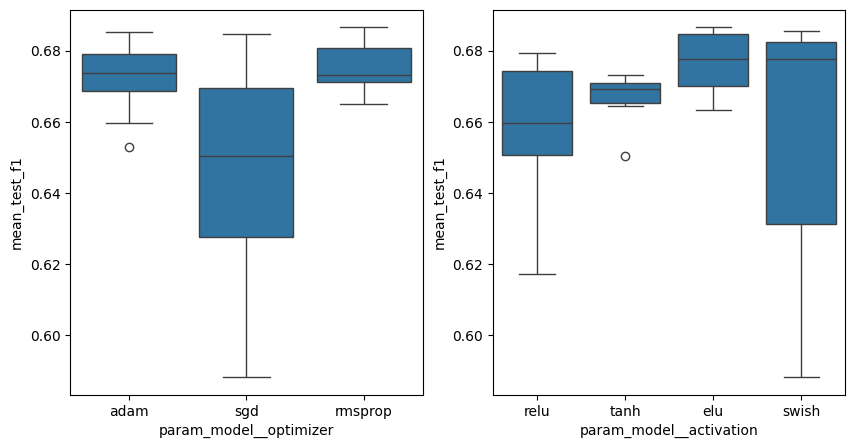

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results, x='param_model__optimizer', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results, x='param_model__activation', y='mean_test_f1', ax=ax[1])


In [9]:
keras_scores_test.describe()

,accuracy,precision,recall,f1
count,3.000000,3.000000,3.000000,3.000000
mean,0.764919,0.706333,0.677857,0.685925
std,0.001349,0.004395,0.003081,0.002790
min,0.763390,0.701268,0.674303,0.683934
25%,0.764407,0.704933,0.676904,0.684331
50%,0.765424,0.708598,0.679506,0.684728
75%,0.765683,0.708866,0.679635,0.686921
max,0.765943,0.709134,0.679764,0.689114


In [10]:
keras_scores_train.describe()

,accuracy,precision,recall,f1
count,3.000000,3.000000,3.000000,3.000000
mean,0.823915,0.795569,0.752304,0.766979
std,0.006871,0.005925,0.011605,0.009970
min,0.819261,0.792074,0.742683,0.758842
25%,0.819969,0.792148,0.745859,0.761418
50%,0.820678,0.792223,0.749035,0.763994
75%,0.826243,0.797316,0.757114,0.771047
max,0.831807,0.802410,0.765193,0.778100


In [169]:
keras_estimators

[KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=elu
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=

In [12]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [108, 144, 180],
    'model__hidden_neurons2': [72],      
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu', 'elu', 'swish'],
}
keras_estimators_2, keras_scores_train_2, keras_scores_test_2, keras_cv_results_2 = train(features, targets, keras_sequential, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

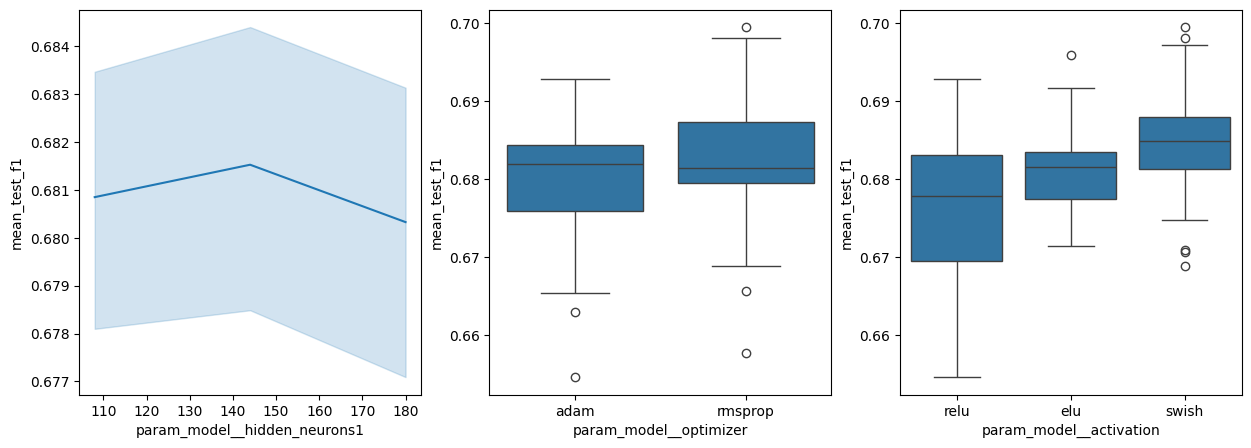

In [13]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=keras_cv_results_2, x='param_model__hidden_neurons1', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_2, x='param_model__optimizer', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=keras_cv_results_2, x='param_model__activation', y='mean_test_f1', ax=ax[2])

In [14]:
keras_scores_test_2.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.761979,0.702489,0.675901,0.682652
std,0.007968,0.010372,0.007676,0.008314
min,0.750282,0.687853,0.665457,0.670964
25%,0.757919,0.697079,0.672993,0.678507
50%,0.764972,0.703701,0.676767,0.684730
75%,0.766102,0.709904,0.677704,0.686085
max,0.770621,0.713906,0.686585,0.692975


In [15]:
keras_scores_train_2.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.823463,0.793742,0.753684,0.766882
std,0.016420,0.022725,0.027318,0.027618
min,0.806725,0.774882,0.719441,0.733043
25%,0.817514,0.782320,0.741149,0.756066
50%,0.818028,0.787721,0.751873,0.763030
75%,0.824527,0.790869,0.762623,0.773852
max,0.850523,0.832920,0.793335,0.808421


In [16]:
keras_estimators_2

[KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=elu
 	model__hidden_neurons1=180
 	model__hidden_neurons2=72
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=

In [17]:
keras_class_param = {
    'batch_size': [20],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36, 72, 108],      
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation': ['relu','swish'],
}
keras_estimators_3, keras_scores_train_3, keras_scores_test_3, keras_cv_results_3 = train(features, targets, keras_sequential, keras_class_param, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_model__activation', ylabel='mean_test_f1'>

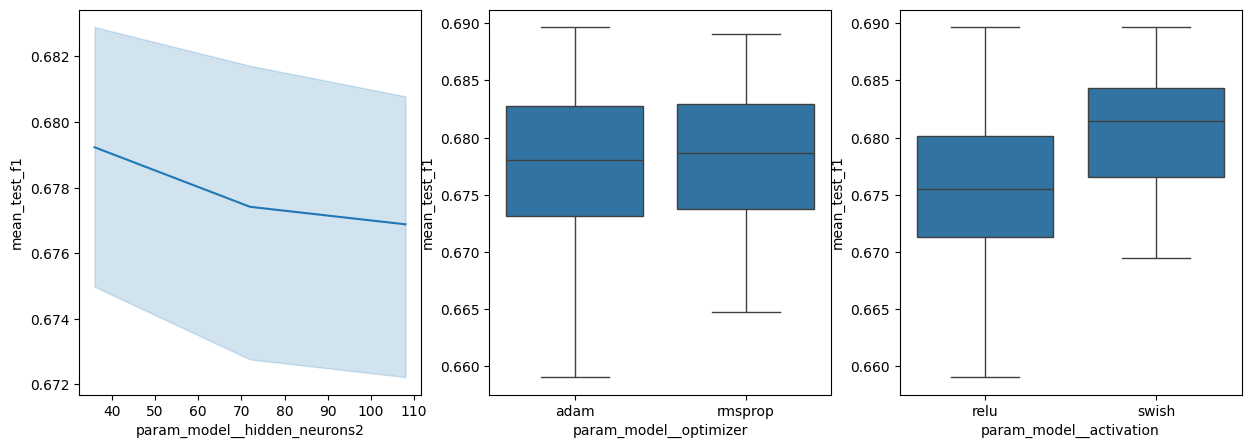

In [18]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=keras_cv_results_3, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=keras_cv_results_3, x='param_model__optimizer', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=keras_cv_results_3, x='param_model__activation', y='mean_test_f1', ax=ax[2])

In [19]:
keras_scores_test_3.describe()

,accuracy,precision,recall,f1
count,3.000000,3.000000,3.000000,3.000000
mean,0.753392,0.693886,0.667994,0.675324
std,0.005175,0.002880,0.009686,0.007954
min,0.749153,0.691667,0.660044,0.668283
25%,0.750508,0.692259,0.662600,0.671010
50%,0.751864,0.692851,0.665156,0.673737
75%,0.755512,0.694995,0.671969,0.678844
max,0.759159,0.697140,0.678781,0.683952


In [20]:
keras_scores_train_3.describe()

,accuracy,precision,recall,f1
count,3.000000,3.000000,3.000000,3.000000
mean,0.851270,0.834232,0.791302,0.806626
std,0.029724,0.036622,0.047750,0.046295
min,0.816949,0.792450,0.736357,0.753175
25%,0.842520,0.820964,0.775579,0.792932
50%,0.868091,0.849479,0.814802,0.832689
75%,0.868430,0.855123,0.818775,0.833351
max,0.868769,0.860767,0.822748,0.834014


In [170]:
keras_estimators_3

[KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=relu
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=adam
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=relu
 	model__hidden_neurons1=144
 	model__hidden_neurons2=72
 	model__optimizer=rmsprop
 ),
 KerasClassifier(
 	model=<function create_model at 0x000002350AD29E40>
 	build_fn=None
 	warm_start=

In [22]:
def create_model_2(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=72, learing_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learing_rate), loss=loss, metrics=['accuracy'])
    return model

In [23]:
keras_class_param = {
    'batch_size': [10, 20, 30],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.0001, 0.0005, 0.0008, 0.001],
}
keras_sequential_2 = KerasClassifier(model=create_model_2, verbose=0)
keras_estimators_4, keras_scores_train_4, keras_scores_test_4, keras_cv_results_4 = train(features, targets, keras_sequential_2, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__learing_rate', ylabel='mean_test_f1'>

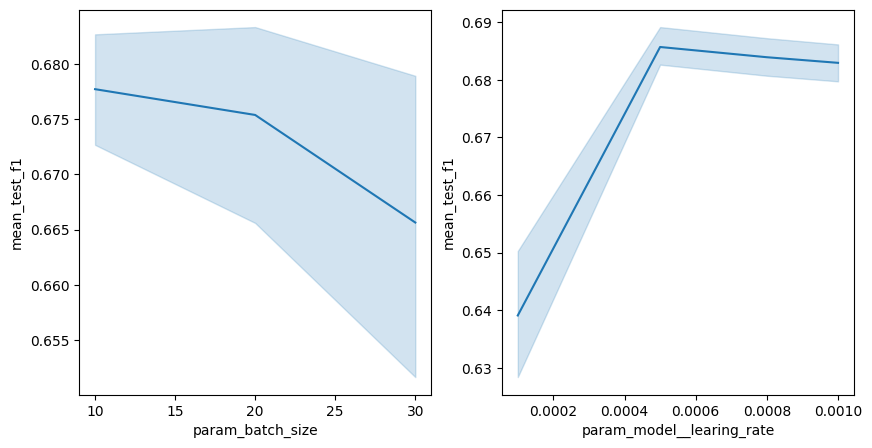

In [24]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.lineplot(data=keras_cv_results_4, x='param_batch_size', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_4, x='param_model__learing_rate', y='mean_test_f1', ax=ax[1])


In [25]:
keras_scores_test_4.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.759493,0.699649,0.676924,0.684135
std,0.010231,0.009532,0.013338,0.012163
min,0.744633,0.686494,0.658162,0.667260
25%,0.756787,0.695477,0.673251,0.680982
50%,0.760452,0.701908,0.675741,0.682969
75%,0.762712,0.701972,0.683001,0.688770
max,0.772881,0.712395,0.694467,0.700693


In [26]:
keras_scores_train_4.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.811200,0.772392,0.741316,0.752608
std,0.015494,0.023347,0.021457,0.022510
min,0.797683,0.753570,0.719835,0.731462
25%,0.802204,0.755065,0.729875,0.738325
50%,0.804465,0.766166,0.730229,0.743040
75%,0.815254,0.776416,0.754438,0.763450
max,0.836394,0.810745,0.772205,0.786763


In [27]:
keras_estimators_4

[KerasClassifier(
 	model=<function create_model_2 at 0x0000023665D83B00>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=20
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.0005
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x0000023665D83B00>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=30
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.0005
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x0000023665D83B00>
 	build_fn=Non

In [28]:
keras_class_param = {
    'batch_size': [5, 10],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.0005, 0.001, 0.0025, 0.005],
}
keras_estimators_5, keras_scores_train_5, keras_scores_test_5, keras_cv_results_5 = train(features, targets, keras_sequential_2, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__learing_rate', ylabel='mean_test_f1'>

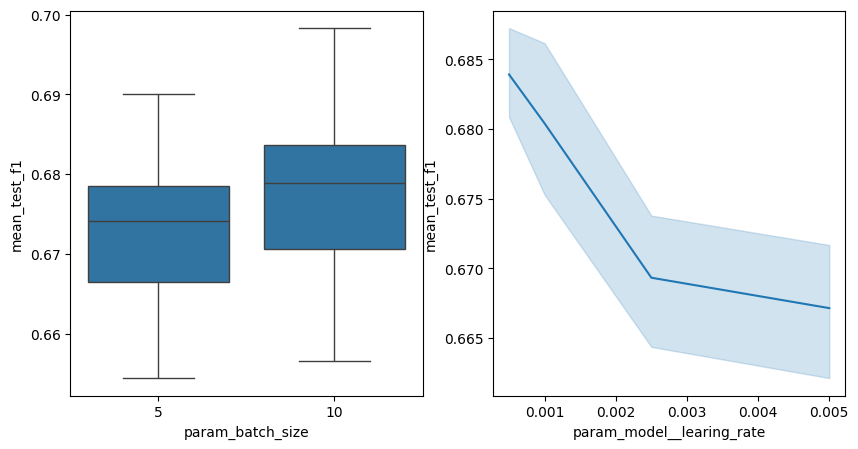

In [29]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_5, x='param_batch_size', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_5, x='param_model__learing_rate', y='mean_test_f1', ax=ax[1])

In [30]:
keras_scores_test_5.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.769213,0.716230,0.690941,0.699625
std,0.014610,0.020030,0.017997,0.018976
min,0.744633,0.681974,0.661518,0.668107
25%,0.769231,0.719070,0.687555,0.697971
50%,0.771751,0.722364,0.696661,0.705866
75%,0.779661,0.723126,0.701424,0.708479
max,0.780791,0.734616,0.707548,0.717704


In [31]:
keras_scores_train_5.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.823067,0.790822,0.757756,0.770066
std,0.012344,0.019082,0.015978,0.016975
min,0.809833,0.768230,0.736204,0.747873
25%,0.810964,0.773389,0.745255,0.756052
50%,0.825141,0.796053,0.766814,0.778202
75%,0.832156,0.806035,0.768516,0.782782
max,0.837242,0.810402,0.771989,0.785422


In [55]:
keras_estimators_5

[KerasClassifier(
 	model=<function create_model_2 at 0x0000023665D83B00>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.0005
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x0000023665D83B00>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.001
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x0000023665D83B00>
 	build_fn=None

In [60]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.0001, 0.0005, 0.001],
}
keras_estimators_9, keras_scores_train_9, keras_scores_test_9, keras_cv_results_9 = train(features, targets, keras_sequential_2, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__learing_rate', ylabel='mean_test_f1'>

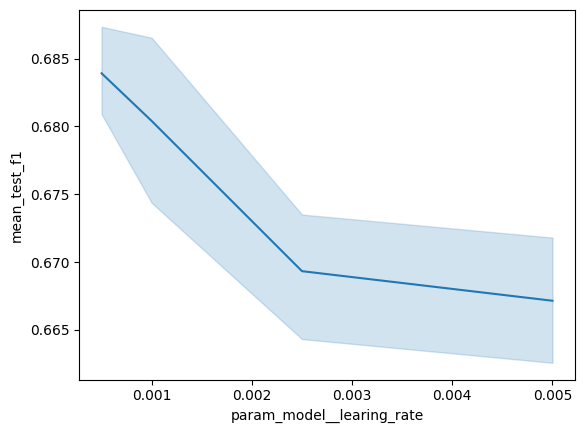

In [91]:
sb.lineplot(data=keras_cv_results_5, x='param_model__learing_rate', y='mean_test_f1')

In [92]:
keras_scores_test_9.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.766501,0.706098,0.678376,0.685766
std,0.012589,0.014331,0.019198,0.018154
min,0.749153,0.686473,0.655809,0.664635
25%,0.759322,0.701225,0.666289,0.674907
50%,0.768100,0.702515,0.674762,0.681921
75%,0.775141,0.718480,0.691441,0.696723
max,0.780791,0.721796,0.703579,0.710645


In [66]:
keras_scores_train_9.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.818095,0.786592,0.742983,0.757179
std,0.005867,0.010235,0.006756,0.006556
min,0.812942,0.777722,0.736004,0.749739
25%,0.813277,0.780133,0.736602,0.750372
50%,0.816332,0.780637,0.745046,0.760929
75%,0.821136,0.792960,0.745086,0.761693
max,0.826787,0.801511,0.752175,0.763164


In [67]:
keras_estimators_9

[KerasClassifier(
 	model=<function create_model_2 at 0x0000023665D83B00>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.0005
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x0000023665D83B00>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons1=144
 	model__hidden_neurons2=36
 	model__learing_rate=0.0005
 ),
 KerasClassifier(
 	model=<function create_model_2 at 0x0000023665D83B00>
 	build_fn=Non

In [54]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons1': [144],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__learing_rate': [0.0005],
}
keras_sequential_estimators_final, keras_sequential_scores_train_final, keras_sequential_scores_test_final, keras_sequential_cv_results_final = train(features, targets, keras_sequential_2, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [58]:
keras_sequential_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.766275,0.709325,0.683974,0.692135
std,0.009394,0.015346,0.013474,0.013808
min,0.751412,0.689292,0.667302,0.674432
25%,0.764972,0.698360,0.675331,0.685965
50%,0.766968,0.711655,0.684322,0.689269
75%,0.771751,0.722243,0.690901,0.700729
max,0.776271,0.725077,0.702015,0.710277


In [59]:
keras_sequential_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.815721,0.782119,0.745201,0.758015
std,0.001275,0.005677,0.008379,0.007141
min,0.814354,0.777520,0.736277,0.750031
25%,0.815202,0.779249,0.739817,0.753268
50%,0.815485,0.780577,0.744667,0.756276
75%,0.815767,0.781307,0.747066,0.763011
max,0.817797,0.791942,0.758179,0.767487


In [93]:
def create_model_3(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=36, dropout=0.1):
    model = Sequential()
    model.add(Input(shape=(36,)))
    model.add(Dense(hidden_neurons1, activation=activation))
    if(hidden_neurons2 > 0):
        model.add(Dense(hidden_neurons2, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(12, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model

In [94]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish', 'relu'],
    'model__dropout': [0.05, 0.1, 0.15, 0.2]
}
keras_sequential_dropout = KerasClassifier(model=create_model_3, verbose=0)
keras_estimators_6, keras_scores_train_6, keras_scores_test_6, keras_cv_results_6 = train(features, targets, keras_sequential_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

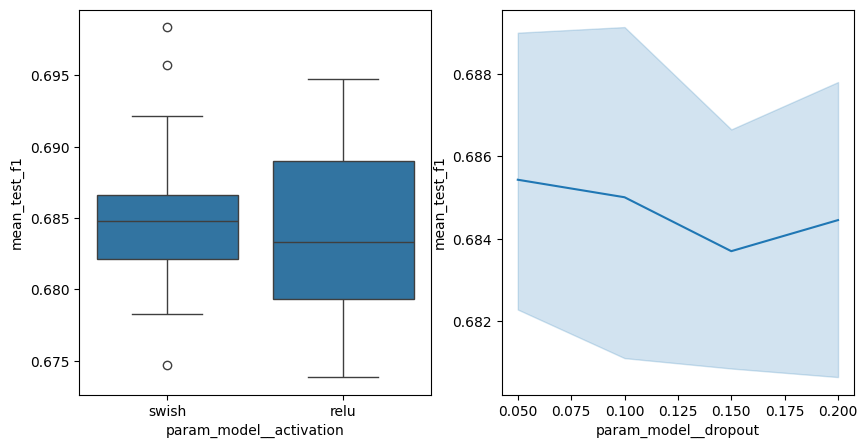

In [95]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_6, x='param_model__activation', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_6, x='param_model__dropout', y='mean_test_f1', ax=ax[1])

In [96]:
keras_scores_test_6.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.766953,0.712366,0.683910,0.692915
std,0.009830,0.015269,0.014414,0.014500
min,0.751412,0.693773,0.666210,0.675300
25%,0.766102,0.703495,0.678688,0.686967
50%,0.766968,0.708591,0.683476,0.691515
75%,0.772881,0.726256,0.685159,0.695859
max,0.777401,0.729715,0.706018,0.714931


In [97]:
keras_scores_train_6.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.820354,0.789276,0.747495,0.761628
std,0.014908,0.020260,0.023354,0.023627
min,0.801356,0.764075,0.713939,0.727997
25%,0.812942,0.777963,0.740722,0.755433
50%,0.816615,0.784595,0.743941,0.756613
75%,0.833898,0.807817,0.765306,0.779980
max,0.836960,0.811929,0.773568,0.788115


In [119]:
keras_estimators_6

[KerasClassifier(
 	model=<function create_model_3 at 0x00000238BC1B4860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons2=36
 ),
 KerasClassifier(
 	model=<function create_model_3 at 0x00000238BC1B4860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.05
 	model__hidden_neurons2=36
 ),
 KerasClassifier(
 	model=<function create_model_3 at 0x00000238BC1B4860>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None


In [120]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [36],
    'model__activation': ['swish'],
    'model__dropout': [0.2]
}
keras_sequential_dropout_estimators_final, keras_sequential_dropout_scores_train_final, keras_sequential_dropout_scores_test_final, keras_sequential_dropout_cv_results_final = train(features, targets, keras_sequential_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [121]:
keras_sequential_dropout_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.765595,0.709271,0.678387,0.686363
std,0.014292,0.017594,0.009002,0.010645
min,0.745763,0.687755,0.667892,0.675116
25%,0.759050,0.700440,0.676088,0.682693
50%,0.764972,0.706553,0.677267,0.684495
75%,0.776271,0.717340,0.677909,0.685562
max,0.781921,0.734266,0.692782,0.703947


In [122]:
keras_sequential_dropout_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.802272,0.761076,0.722418,0.734372
std,0.003259,0.001783,0.009752,0.008982
min,0.797966,0.758450,0.707653,0.720369
25%,0.800282,0.760368,0.717361,0.730596
50%,0.802487,0.761167,0.727416,0.738443
75%,0.804465,0.762535,0.728839,0.740266
max,0.806160,0.762859,0.730822,0.742187


In [123]:
def create_model_4(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=36):
    input = Input(shape=(36,))
    x = (Dense(hidden_neurons1, activation=activation))(input)
    x = (Dense(hidden_neurons2, activation=activation))(x) + (Dense(hidden_neurons2, activation=activation))(input)
    x = (Dense(12, activation=activation))(x)
    x = (Dense(3, activation='softmax'))(x)
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model

In [124]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [24, 36, 48],
    'model__activation': ['swish', 'relu'],
}
keras_model = KerasClassifier(model=create_model_4, verbose=0)
keras_estimators_7, keras_scores_train_7, keras_scores_test_7, keras_cv_results_7 = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__hidden_neurons2', ylabel='mean_test_f1'>

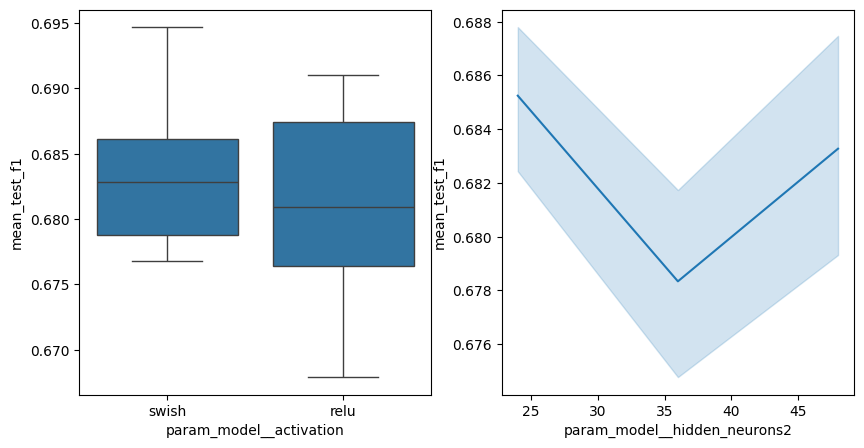

In [125]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sb.boxplot(data=keras_cv_results_7, x='param_model__activation', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=keras_cv_results_7, x='param_model__hidden_neurons2', y='mean_test_f1', ax=ax[1])

In [126]:
keras_scores_test_7.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.764243,0.708088,0.675561,0.684273
std,0.012129,0.011029,0.008177,0.007847
min,0.748023,0.696041,0.665541,0.676160
25%,0.754802,0.698300,0.668723,0.676861
50%,0.769492,0.709247,0.677512,0.684374
75%,0.774011,0.714517,0.681378,0.690176
max,0.774887,0.722335,0.684654,0.693796


In [127]:
keras_scores_train_7.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.827476,0.801695,0.754457,0.770375
std,0.008907,0.012862,0.011126,0.012038
min,0.816102,0.782026,0.739441,0.752988
25%,0.823114,0.799497,0.753382,0.769746
50%,0.826787,0.801811,0.753753,0.770030
75%,0.831591,0.808478,0.754888,0.772197
max,0.839785,0.816661,0.770822,0.786915


In [141]:
keras_estimators_7

[KerasClassifier(
 	model=<function create_model_4 at 0x0000023A77AA2DE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=relu
 	model__hidden_neurons2=36
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x0000023A77AA2DE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__hidden_neurons2=48
 ),
 KerasClassifier(
 	model=<function create_model_4 at 0x0000023A77AA2DE0>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_

In [139]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [24],
    'model__activation': ['swish'],
}
keras_model_estimators_final, keras_model_scores_train_final, keras_model_scores_test_final, keras_model_cv_results_final = train(features, targets, keras_model, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [144]:
keras_model_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.767632,0.708935,0.681500,0.689667
std,0.009909,0.013730,0.011118,0.011841
min,0.753672,0.691568,0.669733,0.676814
25%,0.761582,0.701467,0.672646,0.680431
50%,0.771493,0.710756,0.681898,0.691158
75%,0.772881,0.712426,0.685574,0.693041
max,0.778531,0.728459,0.697651,0.706892


In [145]:
keras_model_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.812557,0.776920,0.737386,0.750556
std,0.001089,0.004546,0.002309,0.002456
min,0.811246,0.769184,0.735416,0.747554
25%,0.811811,0.777187,0.736100,0.749685
50%,0.812712,0.778325,0.736825,0.750449
75%,0.812942,0.778864,0.737275,0.750755
max,0.814072,0.781041,0.741318,0.754339


In [142]:
def create_model_5(loss='sparse_categorical_crossentropy', activation='swish', hidden_neurons1=144, hidden_neurons2=36, dropout=0.1):
    input = Input(shape=(36,))
    x = (Dense(hidden_neurons1, activation=activation))(input)
    x = (Dense(hidden_neurons2, activation=activation))(x) + (Dense(hidden_neurons2, activation=activation))(input)
    x = (Dropout(dropout))(x)
    x = (Dense(12, activation=activation))(x)
    x = (Dense(3, activation='softmax'))(x)
    model = Model(inputs=input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss=loss, metrics=['accuracy'])
    return model

In [143]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [24],
    'model__activation': ['swish'],
    'model__dropout': [0.05, 0.1, 0.15, 0.2]
}
keras_model_dropout = KerasClassifier(model=create_model_5, verbose=0)
keras_estimators_8, keras_scores_train_8, keras_scores_test_8, keras_cv_results_8 = train(features, targets, keras_model_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_model__dropout', ylabel='mean_test_f1'>

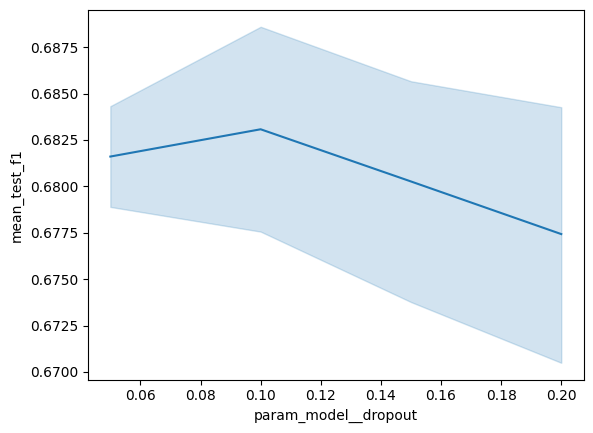

In [150]:
sb.lineplot(data=keras_cv_results_8, x='param_model__dropout', y='mean_test_f1')

In [151]:
keras_scores_test_8.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.760624,0.696865,0.670156,0.676760
std,0.008770,0.013618,0.011364,0.013054
min,0.746893,0.685906,0.653926,0.659078
25%,0.760181,0.686819,0.665291,0.672305
50%,0.760452,0.688750,0.670819,0.673820
75%,0.764972,0.707487,0.677181,0.685696
max,0.770621,0.715362,0.683562,0.692902


In [152]:
keras_scores_train_8.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.808262,0.770546,0.729592,0.742533
std,0.005002,0.008744,0.009224,0.009788
min,0.803052,0.761268,0.720788,0.733605
25%,0.805595,0.763709,0.721435,0.734308
50%,0.805650,0.768390,0.727071,0.738680
75%,0.812094,0.778842,0.739063,0.752562
max,0.814919,0.780521,0.739603,0.753508


In [168]:
keras_estimators_8

[KerasClassifier(
 	model=<function create_model_5 at 0x000002397D93EB60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.05
 	model__hidden_neurons2=24
 ),
 KerasClassifier(
 	model=<function create_model_5 at 0x000002397D93EB60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None
 	metrics=None
 	batch_size=10
 	validation_batch_size=None
 	verbose=0
 	callbacks=None
 	validation_split=0.0
 	shuffle=True
 	run_eagerly=False
 	epochs=10
 	class_weight=None
 	model__activation=swish
 	model__dropout=0.1
 	model__hidden_neurons2=24
 ),
 KerasClassifier(
 	model=<function create_model_5 at 0x000002397D93EB60>
 	build_fn=None
 	warm_start=False
 	random_state=None
 	optimizer=rmsprop
 	loss=None


In [153]:
keras_class_param = {
    'batch_size': [10],
    'epochs': [10],
    'model__hidden_neurons2': [24],
    'model__activation': ['swish'],
    'model__dropout': [0.1]
}
keras_model_dropout_estimators_final, keras_model_dropout_scores_train_final, keras_model_dropout_scores_test_final, keras_model_dropout_cv_results_final = train(features, targets, keras_model_dropout, keras_class_param, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [156]:
keras_model_dropout_scores_test_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.771247,0.713590,0.683468,0.691770
std,0.012017,0.020923,0.014194,0.016456
min,0.758192,0.697422,0.671922,0.679216
25%,0.763842,0.698826,0.672582,0.680191
50%,0.768100,0.702837,0.678365,0.684476
75%,0.777401,0.722451,0.688606,0.696430
max,0.788701,0.746417,0.705864,0.718539


In [157]:
keras_model_dropout_scores_train_final.describe()

,accuracy,precision,recall,f1
count,5.000000,5.000000,5.000000,5.000000
mean,0.805153,0.766074,0.727937,0.740041
std,0.003426,0.007020,0.006622,0.007007
min,0.802487,0.757599,0.720831,0.733332
25%,0.802769,0.764002,0.723560,0.734521
50%,0.803052,0.764917,0.725383,0.737380
75%,0.807290,0.766871,0.734379,0.746272
max,0.810169,0.776983,0.735534,0.748701


In [167]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Accuracy:','Precision:','Recall:', 'F1:'],
    'Keras Sequential Train': [keras_sequential_scores_train_final['accuracy'].mean(),keras_sequential_scores_train_final['precision'].mean(), keras_sequential_scores_train_final['recall'].mean(), keras_sequential_scores_train_final['f1'].mean()],
    'Keras Sequential Test': [keras_sequential_scores_test_final['accuracy'].mean(),keras_sequential_scores_test_final['precision'].mean(), keras_sequential_scores_test_final['recall'].mean(), keras_sequential_scores_test_final['f1'].mean()],
    'Keras Sequential Dropout Train': [keras_sequential_dropout_scores_train_final['accuracy'].mean(),keras_sequential_dropout_scores_train_final['precision'].mean(), keras_sequential_dropout_scores_train_final['recall'].mean(), keras_sequential_dropout_scores_train_final['f1'].mean()],
    'Keras Sequential Dropout Test': [keras_sequential_dropout_scores_test_final['accuracy'].mean(),keras_sequential_dropout_scores_test_final['precision'].mean(), keras_sequential_dropout_scores_test_final['recall'].mean(), keras_sequential_dropout_scores_test_final['f1'].mean()],
    'Keras Model Train': [keras_model_scores_train_final['accuracy'].mean(),keras_model_scores_train_final['precision'].mean(), keras_model_scores_train_final['recall'].mean(), keras_model_scores_train_final['f1'].mean()],
    'Keras Model Test': [keras_model_scores_test_final['accuracy'].mean(),keras_model_scores_test_final['precision'].mean(), keras_model_scores_test_final['recall'].mean(), keras_model_scores_test_final['f1'].mean()],
    'Keras Model Dropout Train': [keras_model_dropout_scores_train_final['accuracy'].mean(),keras_model_dropout_scores_train_final['precision'].mean(), keras_model_dropout_scores_train_final['recall'].mean(), keras_model_dropout_scores_train_final['f1'].mean()],
    'Keras Model Dropout Test': [keras_model_dropout_scores_test_final['accuracy'].mean(),keras_model_dropout_scores_test_final['precision'].mean(), keras_model_dropout_scores_test_final['recall'].mean(), keras_model_dropout_scores_test_final['f1'].mean()],
    })
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,Keras Sequential Train,Keras Sequential Test,Keras Sequential Dropout Train,Keras Sequential Dropout Test,Keras Model Train,Keras Model Test,Keras Model Dropout Train,Keras Model Dropout Test
Metric,,,,,,,,
Accuracy:,0.815721,0.766275,0.802272,0.765595,0.812557,0.767632,0.805153,0.771247
Precision:,0.782119,0.709325,0.761076,0.709271,0.776920,0.708935,0.766074,0.713590
Recall:,0.745201,0.683974,0.722418,0.678387,0.737386,0.681500,0.727937,0.683468
F1:,0.758015,0.692135,0.734372,0.686363,0.750556,0.689667,0.740041,0.691770
